# Introduction to Copulas in R
Some experiments to introduce the idea of copulas and the functions for working with them in R.


In [1]:
suppressMessages(library(here))
library(ggplot2)
library(copula)

source(here('R', 'example-data.R'), echo=FALSE)
source(here('R', 'plots.R'), echo=FALSE)

## Some motivating examples
Consider the following two bivariate datasets.  What can we say about the association between the two variables in each dataset?

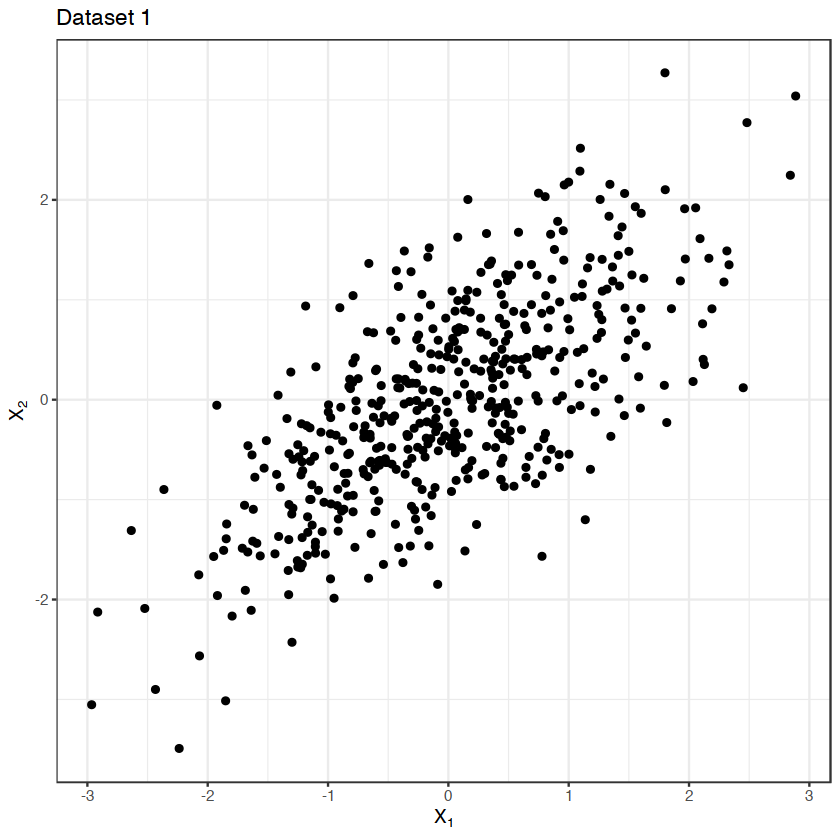

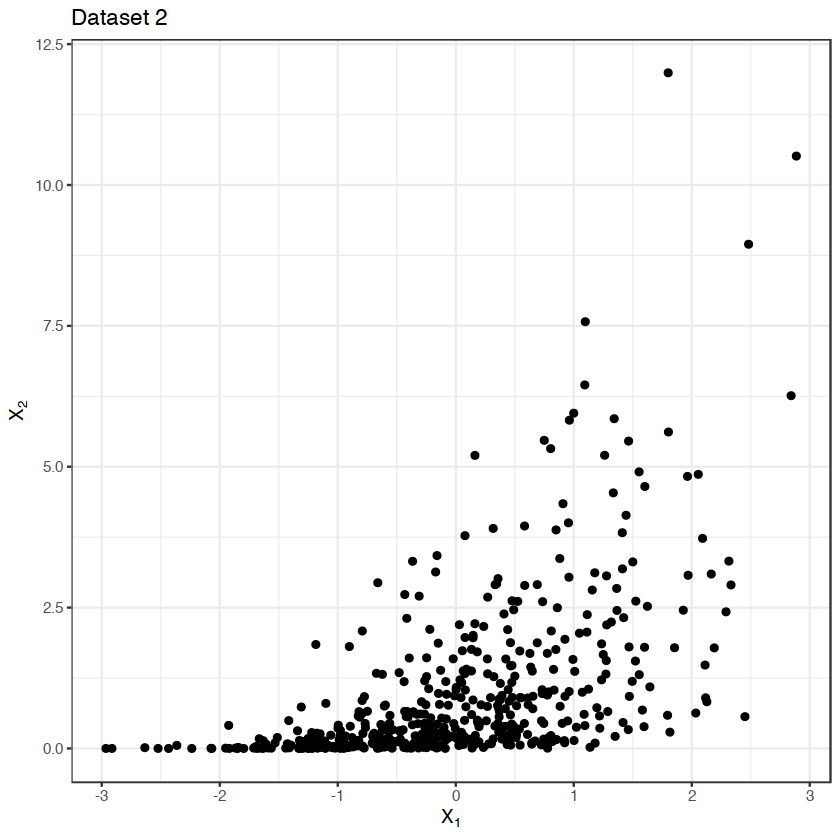

In [2]:
set.seed(867-5309)
examp_data <- exampdata_2d()
scatterplot_mat(examp_data$X1) + ggtitle('Dataset 1')
scatterplot_mat(examp_data$X2) + ggtitle('Dataset 2')

At a glance the two datasets seem wildly different, but it's hard to tell because the marginal distributions are very different ($X_2$ in Dataset 2 is restricted to being positive, for one thing).  If we look at the Kendall's tau statistic for the two datasets, that gives us our first clue that something is up.

In [3]:
cor(examp_data$X1, method='kendall')
cor(examp_data$X2, method='kendall')

1.0000000,0.4741162
0.4741162,1.0000000


1.0000000,0.4741162
0.4741162,1.0000000


The correlation (as measured by $\tau$) is identical, indicating that these two datasets have something fundamental in common, but it is being obscured.  In fact, they are the same dataset, but in the second case the $X_2$ variable has been transformed to a different margin.

We can investigate the underlying structure of the relationship between the two variables by transforming each variable to a standard uniform marginal distribution.  The joint distribution that you get by doing this is called the _copula_ of the distribution.

Ordinarily, when presented with a distribution like this, we wouldn't know what the true marginal distributions of the variables are, but in this case we picked the marginals when we generated the data, so we know that all of the variables are standard normal, except for $X_2$ in Dataset 2, which is a $\chi^2$ with one degree of freedom.

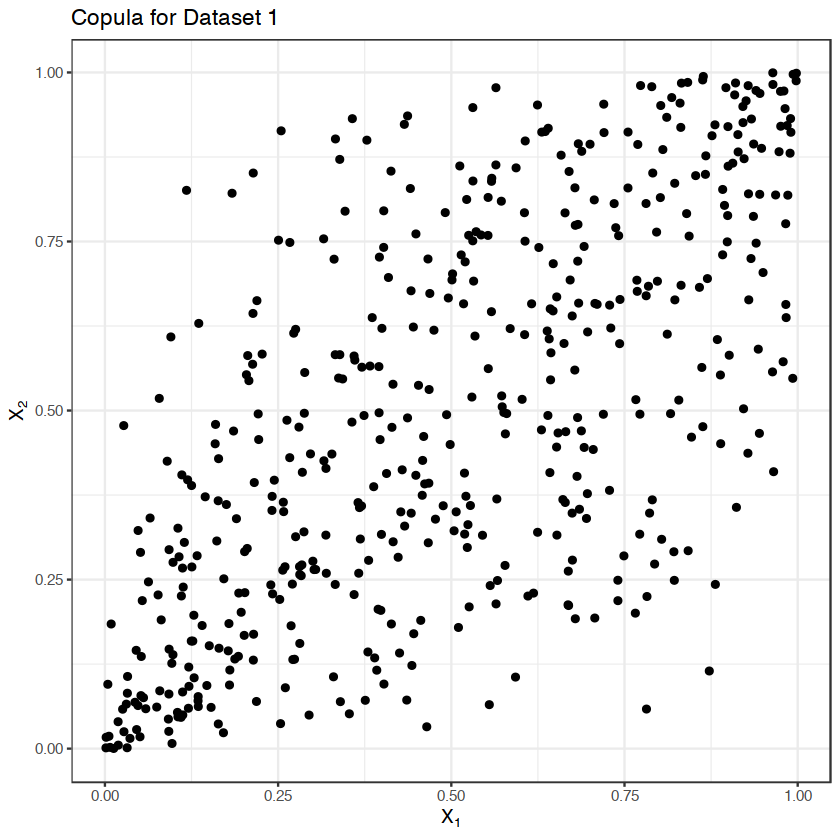

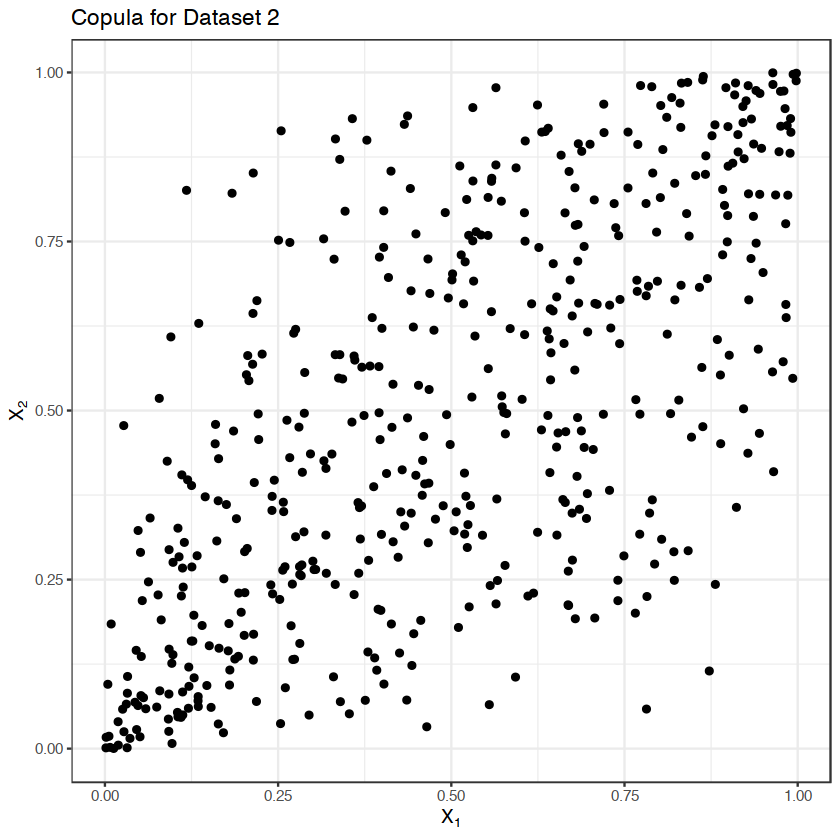

In [4]:
cop1 <- pnorm(examp_data$X1)
cop2 <- pnorm(examp_data$X2); cop2[,2] <- pchisq(examp_data$X2[,2], df=1)
scatterplot_mat(cop1) + ggtitle('Copula for Dataset 1')
scatterplot_mat(cop2) + ggtitle('Copula for Dataset 2')

On closer inspection we can see that the copulas for the two datasets are identical.  The apparent difference in the relationship between the two variables was just an illusion caused by the different marginal distribution of $X_2$ in the second dataset.

The conclusion we get from all of this is that when we care about the joint distribution of two or more variables, studying the copulas of the distributions can show the relationships between the variables more clearly.  We can use copulas to model random variables with specified relationships, to understand the relationships in multivariate data collected in the wild, or to model random processes that produce multivariate output.

## Types of copulas and functions for working with them